https://github.com/mrdbourke/tensorflow-deep-learning

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from sklearn.datasets import make_circles
from tensorflow.keras.utils import plot_model
from tqdm.keras import TqdmCallback
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import pandas as pd

tf.__version__

'2.5.0'

# EfficientNetB0 as Functional Model

In [ ]:
%%capture

!wget -nc "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
!unzip -o "10_food_classes_10_percent"

In [ ]:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory('10_food_classes_10_percent/train',
                                          batch_size=32,
                                          seed=123,
                                          target_size=(224, 224),
                                          class_mode='categorical')

val = val_datagen.flow_from_directory('10_food_classes_10_percent/test',
                                      batch_size=32,
                                      seed=32,
                                      target_size=(224, 224),
                                      class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


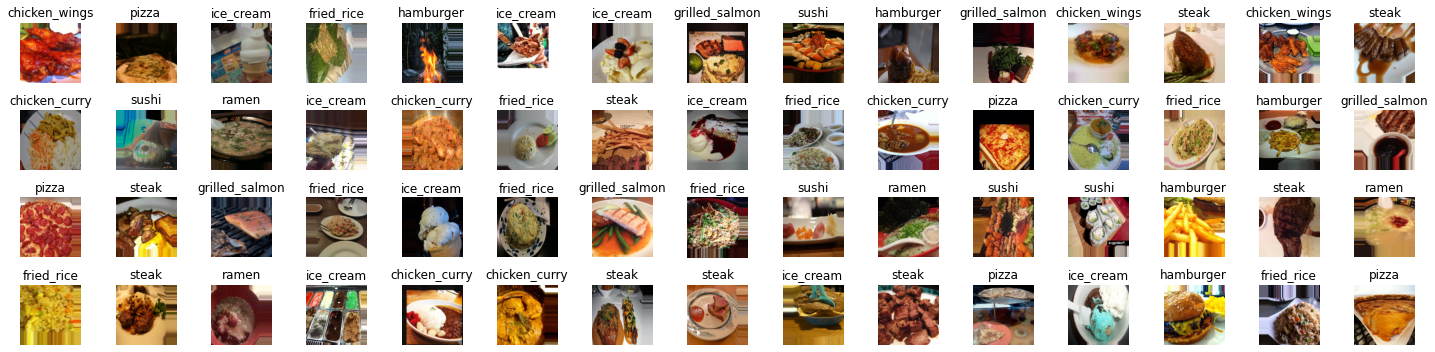

In [ ]:
# Get the images from a batch
imgs = train.next()
labels = list(train.class_indices.keys())

# Plot
plt.figure(figsize=(20, 5))
cols, rows = 15, 4
for i in range(cols * rows):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[0][i])
    plt.title(labels[np.argmax(imgs[1][i])])
    plt.axis('off')

plt.tight_layout();

In [ ]:
# EfficientNet
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
efficientnet = tf.keras.Model(inputs, outputs)

efficientnet.compile(loss='categorical_crossentropy',
                     optimizer='adam', 
                     metrics=['accuracy'])

h = efficientnet.fit(train,
                     validation_data=val,
                     epochs=5,
                     steps_per_epoch=len(train),
                     validation_steps=int(0.25 * len(val)),
                     callbacks=[TqdmCallback(verbose=0)], verbose=0)

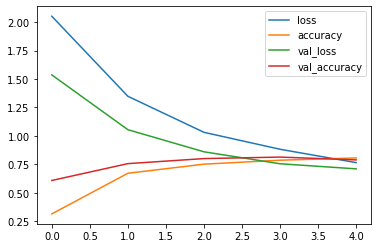

In [ ]:
pd.DataFrame(h.history).plot();

# EfficientNetB0 with 1% training data, Augmentation within the model

In [ ]:
%%capture

!wget -nc "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip"
!unzip -o "10_food_classes_1_percent"

In [ ]:
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory('10_food_classes_1_percent/train',
                                                                           label_mode='categorical',
                                                                           image_size=(224, 224),
                                                                           batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory('10_food_classes_1_percent/test',
                                                                label_mode='categorical',
                                                                image_size=(224, 224),
                                                                batch_size=32)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation = tf.keras.models.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
])

In [ ]:
# EfficientNet
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Model
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
efficientnet = tf.keras.Model(inputs, outputs)

efficientnet.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

h = efficientnet.fit(train_data_1_percent,
                     validation_data=test_data,
                     epochs=5,
                     steps_per_epoch=len(train_data_1_percent),
                     validation_steps=int(0.25 * len(test_data)),
                     callbacks=[TqdmCallback(verbose=0)], verbose=0)

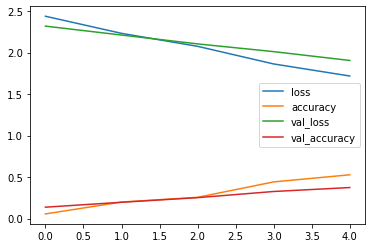

In [ ]:
pd.DataFrame(h.history).plot();